<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   10.12.2023
* Student: Max Hammer
* Immatriculation ID: 11153562

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [154]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')

## load build-in dataset
take the titanic data set

In [155]:
train_data = pd.read_csv('./data/titanic//train.csv', index_col=0)
test_data = pd.read_csv('./data/titanic//test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [156]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df

# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Build a simple vanilla ANN, compile and fit the model.

In [157]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100


14/14 [==============================] - 0s 914us/step - loss: 0.7466 - accuracy: 0.4590
Epoch 2/100
14/14 [==============================] - 0s 870us/step - loss: 0.6725 - accuracy: 0.6420
Epoch 3/100
14/14 [==============================] - 0s 827us/step - loss: 0.6531 - accuracy: 0.6611
Epoch 4/100
14/14 [==============================] - 0s 719us/step - loss: 0.6344 - accuracy: 0.6891
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.6174 - accuracy: 0.7048
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5772 - accuracy: 0.7464
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5696 - accuracy: 0.7497
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.7385
Epoch 9/100
14/14 [==============================] - 0s 863us/step - loss: 0.5378 - accuracy: 0.7587
Epoch 10/100
14/14 [==============================] - 0s 933us/step - loss: 0.5293 - accuracy: 0.7565
Epoch 11/

### Now, compute the Shapley values

In [158]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

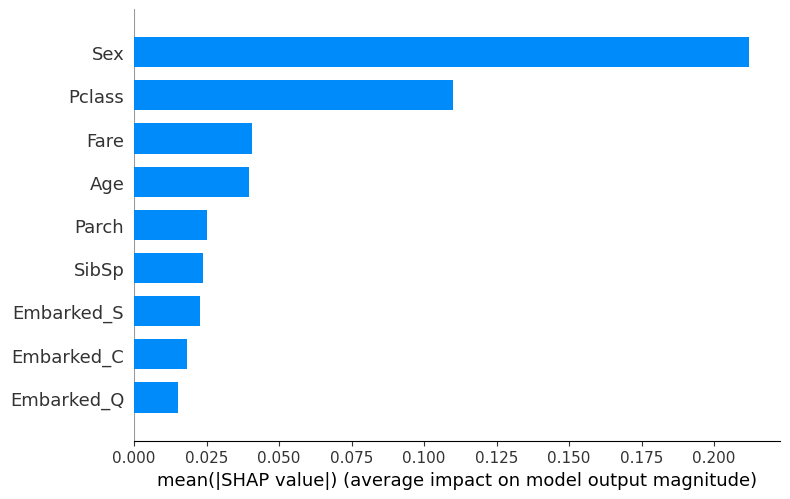

In [159]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [160]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.columns)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

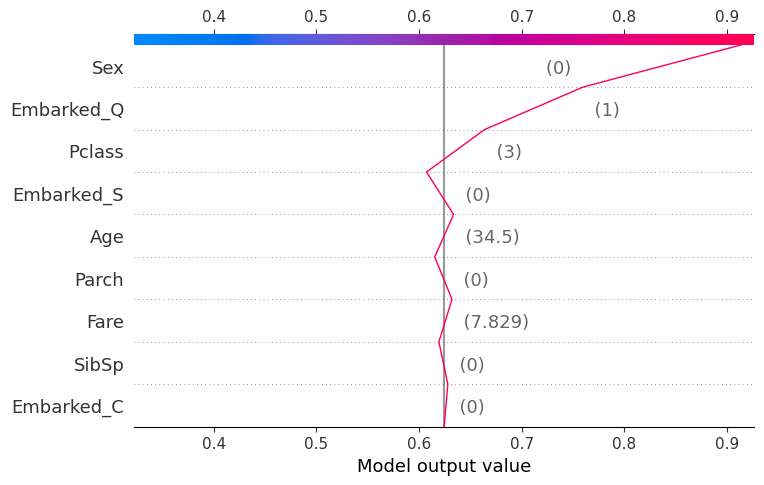

In [161]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0,:], 
                   feature_names = test_data.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

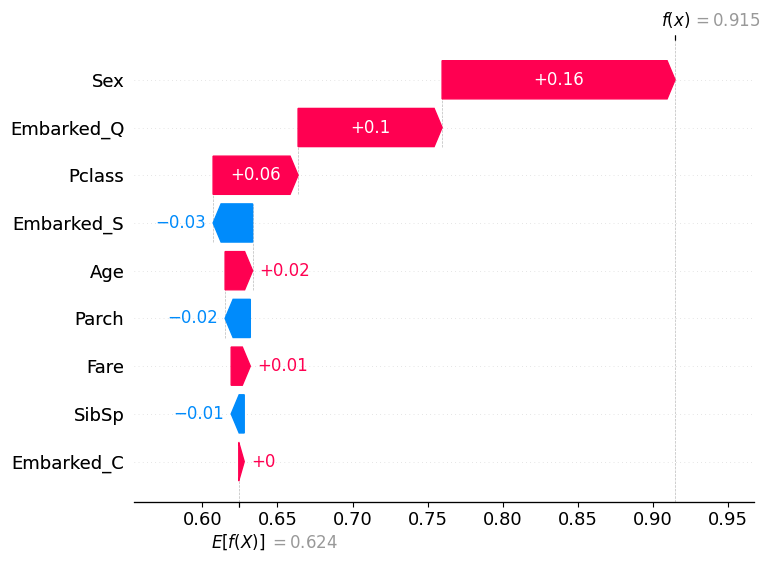

In [162]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], 
                                       feature_names = test_data.columns)

# Task: Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.

In [163]:
# Load Image dataset
import random
import os
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from PIL import Image

class_names=sorted(os.listdir('./data/sports/train'))

# only keep 10 classes
class_names=class_names[:10]
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))  

path_label0=[]
for dirname, _, filenames in os.walk('./data/sports/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg' and dirname.split('/')[-1] in class_names:
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label0+=[(path,normal_mapping[label])]
        
tpath_label0=[]
for dirname, _, filenames in os.walk('./data/sports/test'):
    for filename in filenames:
        if filename[-4:]=='.jpg' and dirname.split('/')[-1] in class_names:
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            tpath_label0+=[(path,normal_mapping[label])]

print(len(path_label0))
print(len(tpath_label0))
    
path_label = random.sample(path_label0, 1000)  
tpath_label = random.sample(tpath_label0, 20) 

import pandas as pd
from PIL import Image
import numpy as np

def images_to_arrays(tuples_list, target_size=(128, 128), normalize=True):
    """
    Convert images specified in a list of tuples to NumPy arrays.
    
    :param tuples_list: List of tuples, each containing an image path.
    :param image_index: Index in the tuple where the image path is stored.
    :return: List of NumPy arrays representing the images.
    """
    image_arrays = []
    image_labels = []
    for item in tuples_list:
        image_path = item[0]
        image_label  = item[1]
        try:
            image = Image.open(image_path)
            if target_size:
                image = image.resize(target_size)
             # Convert to RGB if not already
            if image.mode != 'RGB':
                image = image.convert('RGB')
        
            image_array = np.array(image)
            if normalize:
                image_array = image_array.astype('float32') / 255
            image_array =np.array(image_array)
            image_arrays.append(image_array)
            image_labels.append(image_label)
        except IOError:
            print(f"Error in reading {image_path}. Skipping.")

    return np.array(image_arrays), np.array(image_labels)

# load images as arrays
img_size = (128, 128)
x_train, y_train = images_to_arrays(path_label, target_size=img_size)
x_test, y_test = images_to_arrays(tpath_label, target_size=img_size)


1289
50


To make it easier and faster for demonstration purposes we are going to reduce the data set to only 10 different classes and strip the dataset from all other images accordingly.

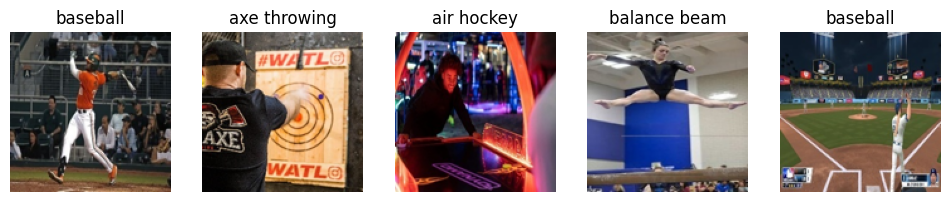

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the first 5 images
n = 5
fig, axes = plt.subplots(1,n, figsize=(12,12))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(x_train[i])
    plt.title(reverse_mapping[y_train[i]])
    plt.axis('off')
plt.show()

In [165]:
# Create CNN model
import tensorflow as tf

inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.legacy.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
32/32 [==============================] - 2s 64ms/step - loss: 5.8924 - sparse_categorical_accuracy: 0.1490 - val_loss: 2.2237 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/10
32/32 [==============================] - 2s 71ms/step - loss: 1.9943 - sparse_categorical_accuracy: 0.2970 - val_loss: 1.9830 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/10
32/32 [==============================] - 2s 61ms/step - loss: 1.4777 - sparse_categorical_accuracy: 0.5320 - val_loss: 1.5386 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/10
32/32 [==============================] - 2s 60ms/step - loss: 0.9484 - sparse_categorical_accuracy: 0.7100 - val_loss: 1.6626 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
32/32 [==============================] - 2s 61ms/step - loss: 0.5582 - sparse_categorical_accuracy: 0.8630 - val_loss: 1.4464 - val_sparse_categorical_accuracy: 0.6500
Epoch 6/10
32/32 [==============================] - 2s 69ms/step - loss: 0.3056 - sparse_categorical_accu

In [166]:
# Compute predictions
predictions = model.predict(x_test)
predicted_class = np.argmax(predictions, axis=1)

# compute accuracy
accuracy = np.mean(predicted_class == y_test)
print(f"Accuracy on total test set: {accuracy * 100}%")

# Compute predictions
predictions = model.predict(x_train)
predicted_class = np.argmax(predictions, axis=1)

# compute accuracy
accuracy = np.mean(predicted_class == y_train)
print(f"Accuracy on total train set: {accuracy * 100}%")

1/1 [==============================] - 0s 46ms/step
Accuracy on total test set: 65.0%
32/32 [==============================] - 1s 16ms/step
Accuracy on total train set: 100.0%


In [168]:
# predict on the test set.

# number of classes to show
n = 5
# example image for each class
images_dict = dict()

for i, l in enumerate(y_train):
    if len(images_dict)==n:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((128, 128,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict)==n:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
        
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

# compute accuracy
accuracy = np.mean(predicted_class == sorted(x_test_dict))
print(f"Accuracy on subset of test set: {accuracy * 100}%")

# Prediction performance are rather medicore, but we will still use this model to demonstrate SHAP.

1/1 [==============================] - 0s 48ms/step
Accuracy on subset of test set: 100.0%


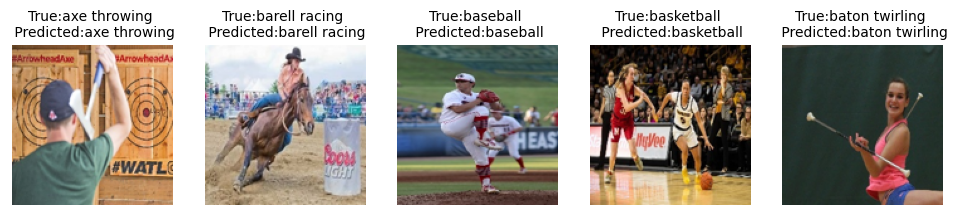

In [169]:
# plot actual and predicted class
fig, axes = plt.subplots(1,n, figsize=(12,12))

# get list of x_test_dict  values
for i in range(x_test_each_class.shape[0]):
    plt.subplot(1,x_test_each_class.shape[0],i+1)
    plt.imshow(x_test_each_class[i])
    plt.title(f"True:{reverse_mapping[sorted(x_test_dict)[i]]} \n Predicted:{reverse_mapping[predicted_class[i]]}", size=10)
    plt.axis('off')
plt.show()

In [170]:
# Shapley values
import shap
# select background for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
# use DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# compute the shapley values
shap_values = explainer.shap_values(x_test_each_class)

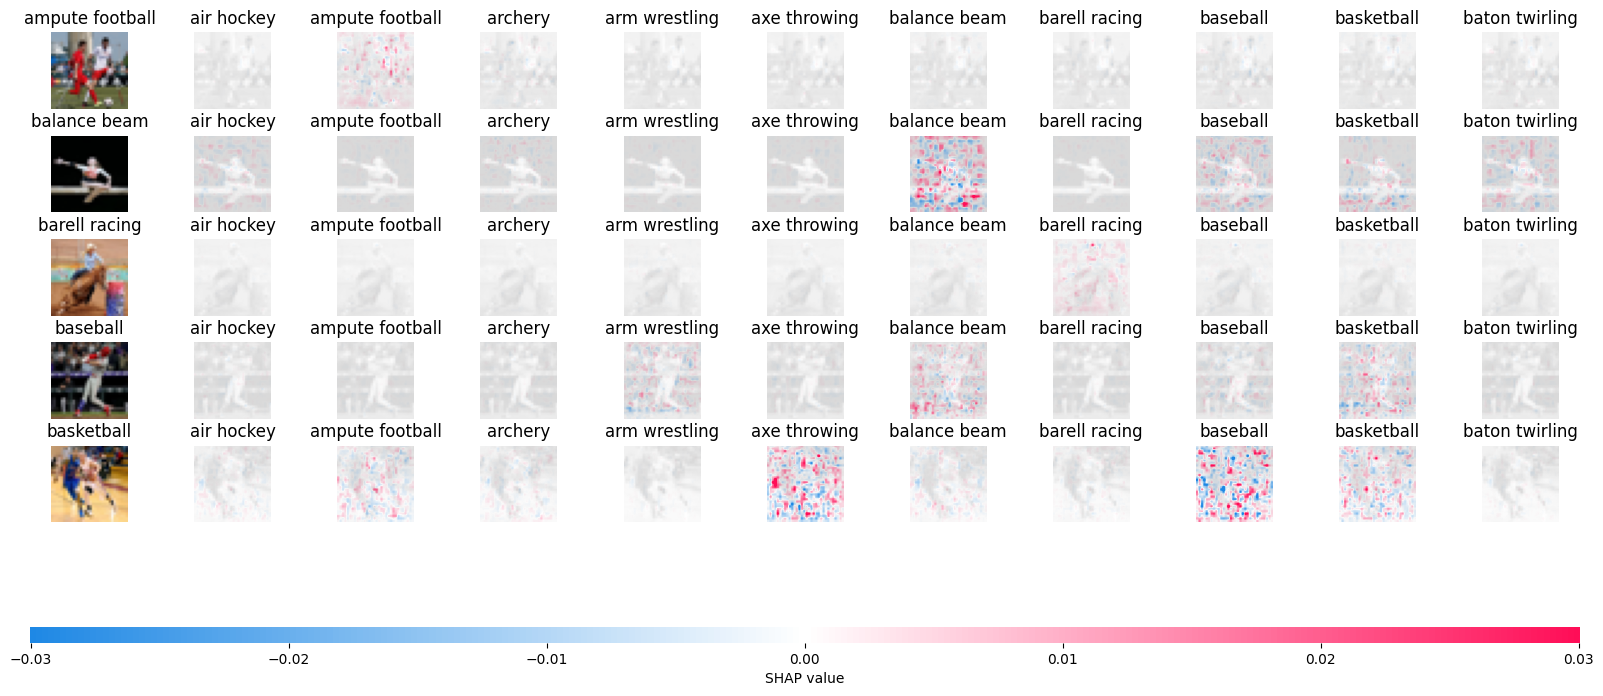

In [ ]:

# create a list with the class names for labeling the samples
true_class_names = np.array([reverse_mapping[i] for i in sorted(x_test_dict)])

# create a list of dim (n_classes, n_images) with the possible class names list
labels = [class_names for _ in range(len(x_test_each_class))]
array_of_labels = np.array(labels)

shap.image_plot(shap_values, x_test_each_class, hspace=.35, labels=array_of_labels, true_labels=list(true_class_names))